In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import udf, col
from pyspark.sql.types import IntegerType, StructType, StructField, StringType
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
import sklearn.metrics
import matplotlib.pyplot as plt

Next 3 cells are for getting the UI from colab.  Run them after all the spark operations.

In [ ]:
!npm install -g localtunnel
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦
added 22 packages in 3s
⠦
⠦3 packages are looking for funding
⠦  run `npm fund` for details
⠦npm notice
npm notice New major version of npm available! 10.8.2 -> 11.3.0
npm notice Changelog: https://github.com/npm/cli/releases/tag/v11.3.0
npm notice To update run: npm install -g npm@11.3.0
npm notice
⠦tar: spark-3.4.1-bin-hadoop3.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
import findspark
findspark.init()

In [ ]:
!curl https://loca.lt/mytunnelpassword
!echo ""
!lt --port 4040

34.125.60.172
your url is: https://plain-trains-speak.loca.lt
^C


In [2]:
spark = SparkSession.builder.master("local[*]").appName("SparkML").getOrCreate()
spark

In [3]:
dfSpark = spark.read.csv("/content/drive/MyDrive/rddPreprocessed", header=True, inferSchema=True)

In [4]:
csvCols = dfSpark.columns
csvCols.remove('intelligence')
featureAssembler = VectorAssembler(inputCols=csvCols, outputCol="mlFeatures")
vaOutput = featureAssembler.transform(dfSpark)
finalizeData = vaOutput.select("mlFeatures", "intelligence")
finalizeData = finalizeData.dropna()
trainData, testData = finalizeData.randomSplit([0.80, 0.20])
finalizeData.show(5)

+--------------------+------------+
|          mlFeatures|intelligence|
+--------------------+------------+
|[0.32208684,0.367...|           0|
|[0.3193533,0.4034...|           0|
|[0.30920026,0.350...|           0|
|[0.30920026,0.364...|           0|
|[0.31380817,0.452...|           0|
+--------------------+------------+
only showing top 5 rows



Accuracy: 0.7240757439134355
f1: 0.7235629425333561
Precision: 0.7236231347367248
Recall: 0.7240757439134355


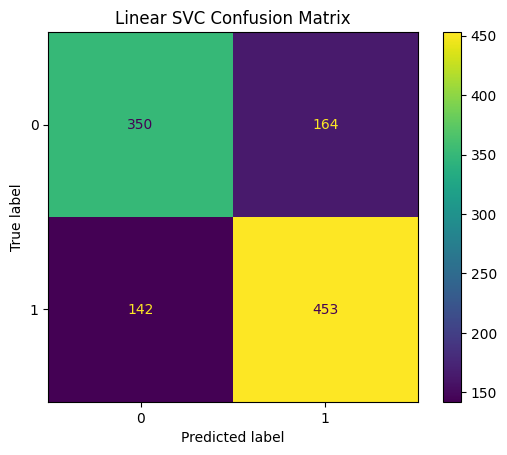

In [6]:
#Linear SVC
spark.sparkContext.setJobGroup("LinearSVC", "Initialize and train LinearSVC Model")
svmModel = LinearSVC(featuresCol="mlFeatures", labelCol="intelligence", regParam=0.01)
accuracyEval = MulticlassClassificationEvaluator(labelCol="intelligence", predictionCol="prediction", metricName="accuracy")
f1Eval = MulticlassClassificationEvaluator(labelCol="intelligence", predictionCol="prediction", metricName="f1")
precisionEval = MulticlassClassificationEvaluator(labelCol="intelligence", predictionCol="prediction", metricName="weightedPrecision")
recallEval = MulticlassClassificationEvaluator(labelCol="intelligence", predictionCol="prediction", metricName="weightedRecall")

svmModel = svmModel.fit(trainData)
predictions = svmModel.transform(testData)
print("Accuracy: " + str(accuracyEval.evaluate(predictions)))
print("f1: " + str(f1Eval.evaluate(predictions)))
print("Precision: " + str(precisionEval.evaluate(predictions)))
print("Recall: " + str(recallEval.evaluate(predictions)))

#make columns into array
yPredictions = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
yTrue = predictions.select("intelligence").rdd.flatMap(lambda x: x).collect()
confusionMatrix = sklearn.metrics.confusion_matrix(y_true=yTrue, y_pred=yPredictions)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusionMatrix)
disp.plot()
plt.title("Linear SVC Confusion Matrix")
plt.show()

Accuracy: 0.7096483318304779
f1: 0.7092242558086775
Precision: 0.7091755765201897
Recall: 0.7096483318304778


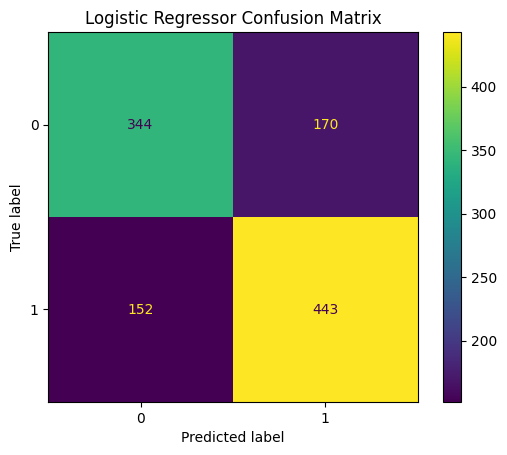

In [7]:
#Logistic Regressor
spark.sparkContext.setJobGroup("LogisticRegression", "Initialize and train LogisticRegression Model")
lrModel = LogisticRegression(featuresCol="mlFeatures", labelCol="intelligence", regParam=0.01)
accuracyEval = MulticlassClassificationEvaluator(labelCol="intelligence", predictionCol="prediction", metricName="accuracy")
f1Eval = MulticlassClassificationEvaluator(labelCol="intelligence", predictionCol="prediction", metricName="f1")
precisionEval = MulticlassClassificationEvaluator(labelCol="intelligence", predictionCol="prediction", metricName="weightedPrecision")
recallEval = MulticlassClassificationEvaluator(labelCol="intelligence", predictionCol="prediction", metricName="weightedRecall")

lrModel = lrModel.fit(trainData)
predictions = lrModel.transform(testData)
print("Accuracy: " + str(accuracyEval.evaluate(predictions)))
print("f1: " + str(f1Eval.evaluate(predictions)))
print("Precision: " + str(precisionEval.evaluate(predictions)))
print("Recall: " + str(recallEval.evaluate(predictions)))

#make columns into array
yPredictions = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
yTrue = predictions.select("intelligence").rdd.flatMap(lambda x: x).collect()
confusionMatrix = sklearn.metrics.confusion_matrix(y_true=yTrue, y_pred=yPredictions)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusionMatrix)
disp.plot()
plt.title("Logistic Regressor Confusion Matrix")
plt.show()

Accuracy: 0.8800721370604148
f1: 0.8793693479582864
Precision: 0.8827842948601621
Recall: 0.8800721370604148


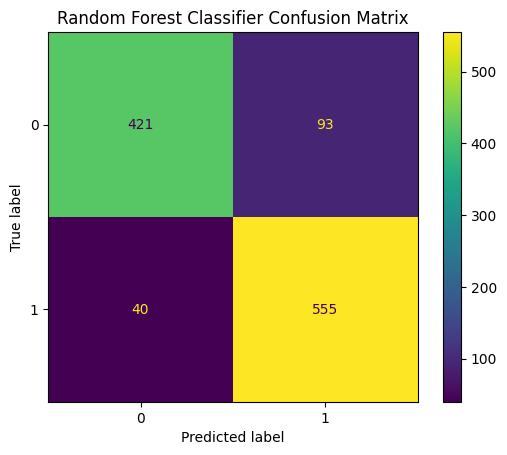

In [8]:
#RF Classifier
spark.sparkContext.setJobGroup("RandomForestClassifier", "Initialize and train RandomForestClassifier Model")
rfClassifier = RandomForestClassifier(
    featuresCol="mlFeatures", labelCol="intelligence",
    numTrees=20, maxDepth=10)
accuracyEval = MulticlassClassificationEvaluator(labelCol="intelligence", predictionCol="prediction", metricName="accuracy")
f1Eval = MulticlassClassificationEvaluator(labelCol="intelligence", predictionCol="prediction", metricName="f1")
precisionEval = MulticlassClassificationEvaluator(labelCol="intelligence", predictionCol="prediction", metricName="weightedPrecision")
recallEval = MulticlassClassificationEvaluator(labelCol="intelligence", predictionCol="prediction", metricName="weightedRecall")

rfClassifier = rfClassifier.fit(trainData)
predictions = rfClassifier.transform(testData)
print("Accuracy: " + str(accuracyEval.evaluate(predictions)))
print("f1: " + str(f1Eval.evaluate(predictions)))
print("Precision: " + str(precisionEval.evaluate(predictions)))
print("Recall: " + str(recallEval.evaluate(predictions)))

#make columns into array
yPredictions = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
yTrue = predictions.select("intelligence").rdd.flatMap(lambda x: x).collect()
confusionMatrix = sklearn.metrics.confusion_matrix(y_true=yTrue, y_pred=yPredictions)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusionMatrix)
disp.plot()
plt.title("Random Forest Classifier Confusion Matrix")
plt.show()

Accuracy: 0.8656447249774571
f1: 0.8650916000844222
Precision: 0.8669463054437441
Recall: 0.8656447249774571


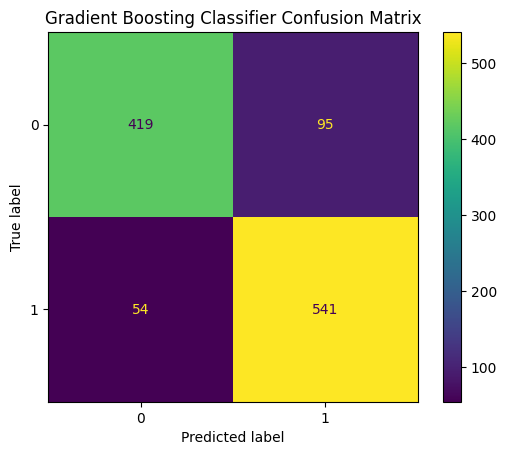

In [9]:
# GBT Classifier
spark.sparkContext.setJobGroup("GBTClassifier", "Initialize and train GBTClassifier Model")
gbtClassifier = GBTClassifier(featuresCol='mlFeatures', labelCol='intelligence',
                                 stepSize=0.1, maxIter=50, maxDepth=4)
accuracyEval = MulticlassClassificationEvaluator(labelCol="intelligence", predictionCol="prediction", metricName="accuracy")
f1Eval = MulticlassClassificationEvaluator(labelCol="intelligence", predictionCol="prediction", metricName="f1")
precisionEval = MulticlassClassificationEvaluator(labelCol="intelligence", predictionCol="prediction", metricName="weightedPrecision")
recallEval = MulticlassClassificationEvaluator(labelCol="intelligence", predictionCol="prediction", metricName="weightedRecall")

gbtClassifier = gbtClassifier.fit(trainData)
predictions = gbtClassifier.transform(testData)
print("Accuracy: " + str(accuracyEval.evaluate(predictions)))
print("f1: " + str(f1Eval.evaluate(predictions)))
print("Precision: " + str(precisionEval.evaluate(predictions)))
print("Recall: " + str(recallEval.evaluate(predictions)))

#make columns into array
yPredictions = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
yTrue = predictions.select("intelligence").rdd.flatMap(lambda x: x).collect()
confusionMatrix = sklearn.metrics.confusion_matrix(y_true=yTrue, y_pred=yPredictions)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusionMatrix)
disp.plot()
plt.title("Gradient Boosting Classifier Confusion Matrix")
plt.show()

Accuracy: 0.6275924256086565
f1: 0.6250232199540384
Precision: 0.6432742309928159
Recall: 0.6275924256086565


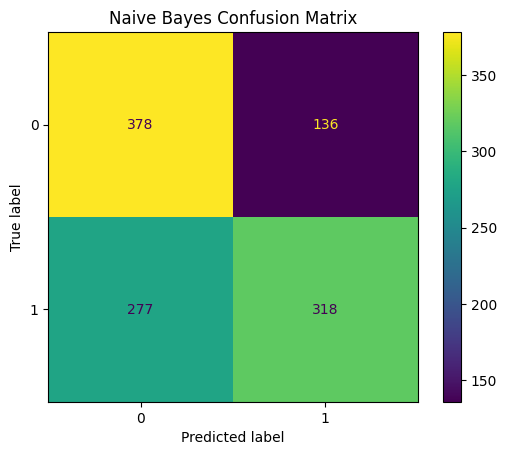

In [10]:
# Naive Bayes
spark.sparkContext.setJobGroup("NaiveBayes", "Initialize and train NaiveBayes Model")
nbModel = NaiveBayes(featuresCol="mlFeatures", labelCol="intelligence", modelType="gaussian")
accuracyEval = MulticlassClassificationEvaluator(labelCol="intelligence", predictionCol="prediction", metricName="accuracy")
f1Eval = MulticlassClassificationEvaluator(labelCol="intelligence", predictionCol="prediction", metricName="f1")
precisionEval = MulticlassClassificationEvaluator(labelCol="intelligence", predictionCol="prediction", metricName="weightedPrecision")
recallEval = MulticlassClassificationEvaluator(labelCol="intelligence", predictionCol="prediction", metricName="weightedRecall")

nbModel = nbModel.fit(trainData)
predictions = nbModel.transform(testData)
print("Accuracy: " + str(accuracyEval.evaluate(predictions)))
print("f1: " + str(f1Eval.evaluate(predictions)))
print("Precision: " + str(precisionEval.evaluate(predictions)))
print("Recall: " + str(recallEval.evaluate(predictions)))

#make columns into array
yPredictions = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
yTrue = predictions.select("intelligence").rdd.flatMap(lambda x: x).collect()
confusionMatrix = sklearn.metrics.confusion_matrix(y_true=yTrue, y_pred=yPredictions)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusionMatrix)
disp.plot()
plt.title("Naive Bayes Confusion Matrix")
plt.show()